# Problem introduction

We explore a scikit-learn [dataset](https://scikit-learn.org/stable/datasets/index.html#breast-cancer-dataset) concerning malignant and begnin breast cancers. Our dataset consists of a feature vector of 30 features and 1 class which can be 0 (Malignant) or 1 (Benign). These features have been extracted from digitized images of cells of breast mass. Thus they describe characteristics of the cell nuclei.

Some of the features
- radius (mean of distances from center to points on the perimeter)
- perimeter
- area 
- concavity (severity of concave portions of the contour)
- smoothness (local variation in radius lengths)

Target classes
- Malignant (0)
- Benign (1)

Our goal is to train a machine learning algorithm to classify -given the 30 features- unseen samples as either malignant or benign. 

The initial choosen Machine learning classifier is Support Vector Machines. We then explore Random Forests and Logistic Regression to see if we can get to a better accuracy.

The model build here performs with a **98.25%** accuracy after tweaking some of the hyperparameters beating in the process the result of a [recent paper](https://www.sciencedirect.com/science/article/pii/S1877050916302575) (97.31%). Which shows how efficient and state-of-the-art scikit-learn really is. Moreover, after hyperparameter tuning it was found that linear kernel performed better than the paper's RBF kernel,

# Machine Learning Algorithm Pipeline

1. Question and the required data
2. Acquire the data
3. Data Analysis
4. Prepare the data for the ML model
5. Train the model
6. Test the model
7. Evaluate the model
8. Interpret the model and report results visually and numerically 
9. Adjust the model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import random
sns.set()

# Get the data
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,precision_score,recall_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Data Analysis

Typically we have these five stages

1. [Tidy Data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html)
2. Missing Values
3. Outliers
4. Class-Imbalance Problem
5. Feature Correlation: visualized using pairplots (optionally one can use a heatmap for visualization)

## Tidy data

In [2]:
features = load_breast_cancer()

# Lets see what this dictionary offers us
print(features.keys())

# Temporarily save the labels
classes = features['target']

# Transform them to pandas dataframe
features = pd.DataFrame(data=features['data'], columns=features['feature_names'])

# Add the labels
features['class'] = classes

features.sample(5)

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
388,11.27,15.50,73.38,392.0,0.08365,0.11140,0.10070,0.02757,0.1810,0.07252,...,18.93,79.73,450.0,0.1102,0.2809,0.3021,0.08272,0.2157,0.10430,1
117,14.87,16.67,98.64,682.5,0.11620,0.16490,0.16900,0.08923,0.2157,0.06768,...,27.37,127.10,1095.0,0.1878,0.4480,0.4704,0.20270,0.3585,0.10650,0
86,14.48,21.46,94.25,648.2,0.09444,0.09947,0.12040,0.04938,0.2075,0.05636,...,29.25,108.40,808.9,0.1306,0.1976,0.3349,0.12250,0.3020,0.06846,0
535,20.55,20.86,137.80,1308.0,0.10460,0.17390,0.20850,0.13220,0.2127,0.06251,...,25.48,160.20,1809.0,0.1268,0.3135,0.4433,0.21480,0.3077,0.07569,0
386,12.21,14.09,78.78,462.0,0.08108,0.07823,0.06839,0.02534,0.1646,0.06154,...,19.29,87.65,529.9,0.1026,0.2431,0.3076,0.09140,0.2677,0.08824,1


In [3]:
print("We have {} features and {} samples.".format(*features.shape))

We have 569 features and 31 samples.


Now that we have a nice pandas dataframe we can continue to the next steps.

## Missing Values & Outliers
A great way to tell if we have missing values or outliers is to compute a summary statistics.

In [4]:
features.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


We can furthermore visualize some of the features. This will also help in getting comfortable with data which is actually crucial.

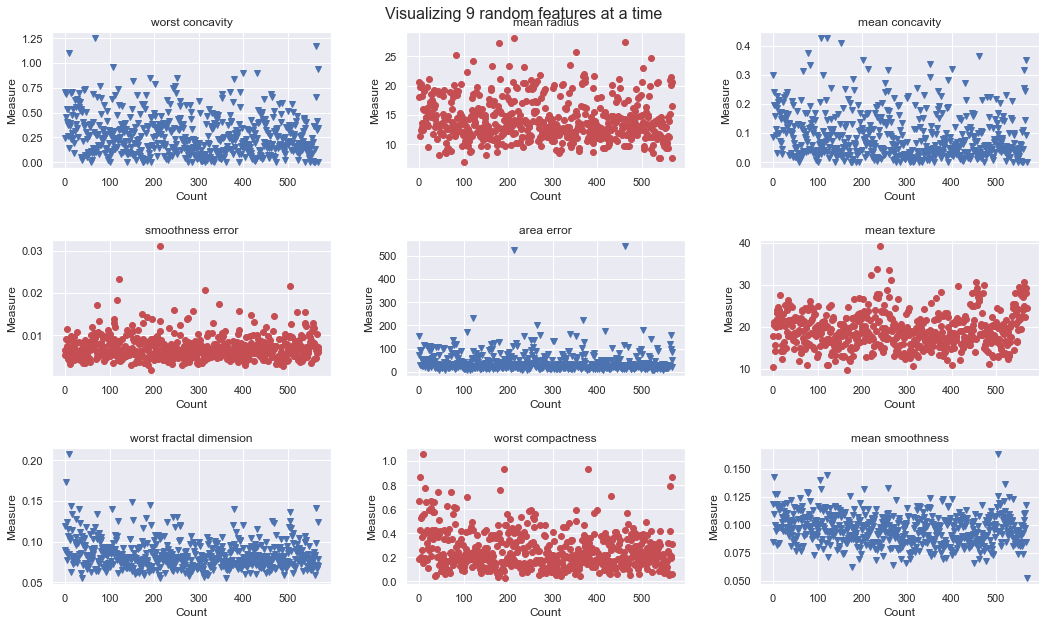

In [5]:
# Randomly pick 9 features to visualize 
plot_features = random.sample(list(features.columns.drop('class')), 9)
plot_features = features[plot_features]

plt.figure(figsize=(15,9))
plt.suptitle("Visualizing 9 random features at a time", fontsize=16)

for i in range(1, plot_features.shape[1]+1):
    # Add a subplot: 3 rows, 3 cols and i represents the index
    plt.subplot(3,3,i)
    
    # Get the current plot
    figure = plt.gca()
    
    # Set the title of the currentplot
    figure.set_title(plot_features.columns[i-1])
        
    # Add some variety to plots
    if i%2==0:
        plt.plot(plot_features.iloc[:, i-1], 'ro')
    else:
        plt.plot(plot_features.iloc[:, i-1], 'v')
    plt.xlabel("Count"); plt.ylabel("Measure")
    
# Give some padding to aboid overlap in graphs
plt.tight_layout(pad=2)

Generally speaking, we have no outliers. Our dataset also has no missing values.

In [6]:
print("Class imbalance problem:")
print(features['class'].value_counts()/features.shape[0])

Class imbalance problem:
1    0.627417
0    0.372583
Name: class, dtype: float64


#### The classes are also balanced.

## Feature Correlation
We can nicely represent this by using a pairplot (alternatively we could also build a heatmap).

Variables tweaked:
- hue: maps plot aspects to different colors. In this case we map two different colors to the two possible classes
- vars: defines the list of features to use, otherwise it uses all the numeric datatypes

The diagonal (which plots each variable against itself is actually showing the distribution of each variable.

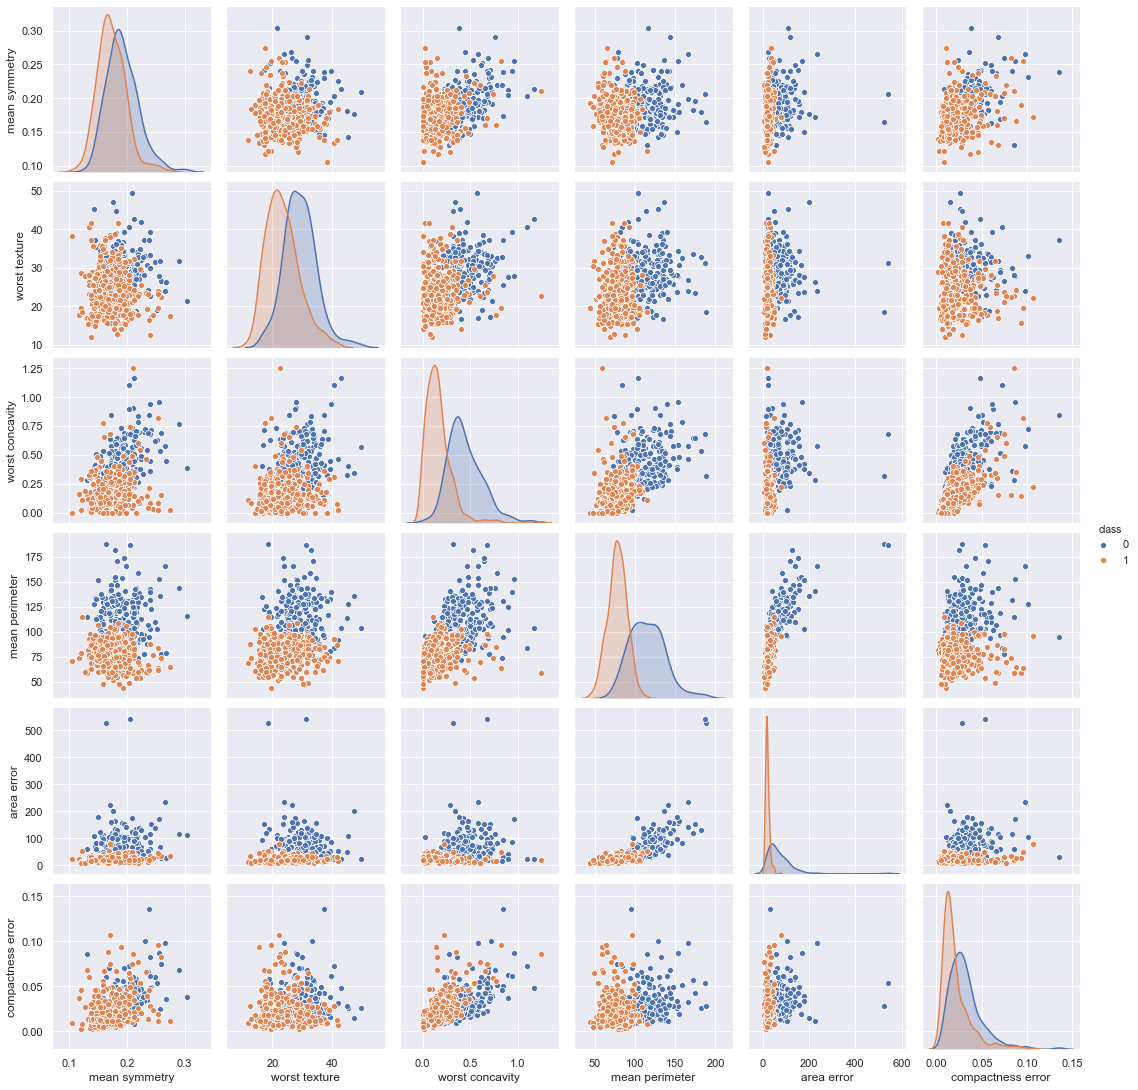

In [7]:
random_feat = random.sample(list(features.columns.drop('class')), 6)
sns.pairplot(data=features, vars=random_feat, hue='class');plt.show()

We can definitely tell that some features are correlated. But most don't seem to be correlated. 

We also see that the values for malignant cases values are actually higher (the radius for instance). Also, our data is truly well-separated.

It is very important to get comfortable with the data early on. This can be realized with such great plots.

# Prepare the data for the Machine Learning Model

1. One-Hot encoding (no need to perform this for our dataset)
2. Split into class/features
3. Split into train/test
4. Scaling/Standartization if needed

Scaling should be performed after spliting into train/test so that future 'unseen' information does not influence our training set 

### Split into class/features

In [8]:
labels = features['class']
features.drop('class', inplace=True, axis=1)

### Split into train/test

In [9]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2,
                                                                           random_state=1)

# Checkout the shape to confirm everything's good
print("The shape of training features", train_features.shape)
print("The shape of training labels", train_labels.shape)
print("The shape of testing features", test_features.shape)
print("The shape of testing labels", test_labels.shape)

The shape of training features (455, 30)
The shape of training labels (455,)
The shape of testing features (114, 30)
The shape of testing labels (114,)


## Feature scaling

We need to perform feature scaling because some measurements (like *fractal dimension error*, check feature plots for a general overview) are in the order of 0.0-0.03 while others (like *worst area*) are 4 order of magnitude larger! This will inevitably confuse our machine learning method because we will use SVM. SVM uses distance measures and thus this distance measure will be influenced much more by features like *worst area*. This essentially means that other features which are not in the same order of magnitude are effectively rendered useless. To avoid this we perform feature scaling. **However, lets quickly run the algorithm without feature scaling to actually see the benefit first hand.**

### First go without feature scaling: Train and Test the model

In [10]:
# Train model
svm = SVC()
svm.fit(train_features, train_labels)

# Test model
predictions = svm.predict(test_features)

print("The accuracy of the model without feature scaling {} %".format(round(
                                                    100*accuracy_score(test_labels, predictions), 2)))

The accuracy of the model without feature scaling 90.35 %


### Perform feature scaling

Possible Scalers: min-max, StandardScaler etc. Which one do we choose?

Choosing a scaler depends entirely on the task, data and algorithm. Only by empirical analysis can we define which one fits better.

- Min-Max normalization: squashes the values in the range of [0,1]. It is practical in tasks where features should be in this range
- StandardScaler: practical in many ML techniques (especially distance based).
- Softmax scaling: Non-linear function which squashes values away from the mean exponentially. Quite practical when the data is not evenly distributed around the mean. 

From sklearn.preprocessing:

- Min-Max: Scale data to the range of [0,1]. No distortion on the data.
- RobustScaler: Dampens the outliers. However, one might want to consider removing the outliers first.
- StandardScaler: subtract the mean and scale to unit variance by dividing by the value of the S.D. However, distorts the relative distance between the feature values. 

We will try out min-max and standard scaler for our model since we have no outliers. 

#### Standard Scaler

In [11]:
# Scale training data
scaler = StandardScaler()

# Transform values
train_features2 = pd.DataFrame(scaler.fit_transform(train_features))

# Set columns
train_features2.columns= train_features.columns

# Set index
train_features2.index = train_features.index.values

test_features2 = pd.DataFrame(scaler.fit_transform(test_features))
test_features2.columns = test_features.columns
test_features2.index = test_features.index.values

#### Min-Max 

In [12]:
scaling = MinMaxScaler(feature_range=(0,1))

train_features3 = pd.DataFrame(scaling.fit_transform(train_features))
train_features3.columns = train_features.columns
train_features3.index = train_features.index.values

test_features3 = pd.DataFrame(scaling.fit_transform(test_features))
test_features3.columns = test_features.columns
test_features3.index = test_features.index.values

# Train the model

In [13]:
# Two models for our two sets of features
svm1 = SVC()
svm2 = SVC()

svm1.fit(train_features2, train_labels);
svm2.fit(train_features3, train_labels);

# Test the model

In [14]:
prediction2 = svm1.predict(test_features2)
prediction3 = svm2.predict(test_features3)

acc1 = 100*accuracy_score(test_labels, predictions)
acc2 = 100*accuracy_score(test_labels, prediction2)
acc3 = 100*accuracy_score(test_labels, prediction3)

print("Accuracy without scaler: {}%".format(round(acc1, 2)))
print("Accuracy with Standard Scaler {}%".format(round(acc2, 2)))
print("Accuracy with Min-Max scaler {}%".format(round(acc3, 2)))

Accuracy without scaler: 90.35%
Accuracy with Standard Scaler 96.49%
Accuracy with Min-Max scaler 97.37%


**So the best scaler is the Min-Max scaler in our case.**

# Evaluate the Model


In [15]:
train_features = train_features3
test_features = test_features3

# Confusion Matrix
confusion_mat = confusion_matrix(test_labels, prediction3)

print("Model accuracy:", round(acc3, 3))
print("Micro precision:", round(100*sum(np.diag(confusion_mat))/sum(sum(confusion_mat)), 2))

print("Precission:", round(100*precision_score(test_labels, prediction3), 2))
print("Recall:", round(100*recall_score(test_labels, prediction3), 2))
print("F1 Score:", round(100*f1_score(test_labels, prediction3), 2))

Model accuracy: 97.368
Micro precision: 97.37
Precission: 97.26
Recall: 98.61
F1 Score: 97.93


## Visualize the confusion matrix
Checkout if this the labels here are correctly working!

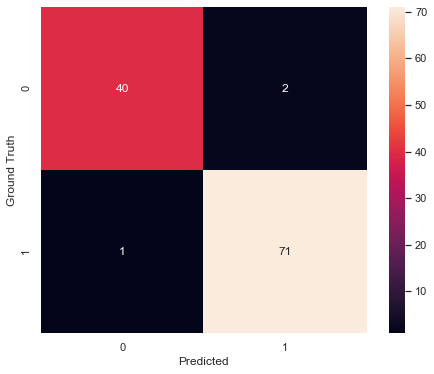

In [16]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_mat, annot=True, square=True, fmt='d', cbar=True)
plt.xlabel("Predicted"); plt.ylabel("Ground Truth"); plt.show()

In [17]:
print("Number of samples per class, real data",collections.Counter(np.array(test_labels)))
print("Number of samples per class, predicted data",collections.Counter(prediction3))

Number of samples per class, real data Counter({1: 72, 0: 42})
Number of samples per class, predicted data Counter({1: 73, 0: 41})


# Adjusting the Model

Our machine learning looks quite nice:
<code>
    svm = SVC()
    svm.fit(train_features, train_labels)
    predictions = svm.predict(test_features)
</code>

3 lines of code to build a model that predicts malignant or begning cancer with 96.5% accuracy. Well this for once shows how powerful -and wonderful- scikit-learn is. But looking at the first line of code *svm = SVC()* we basically did nothing. So lets take a look at possible hyperparameters that we can tweak.

#### Generally speaking there are three ways of adjusting a model and making it better.

Sorted according to their efficiency:

1. **Gather more data.** This should be a thumb up rule. In this case we can't get any other data.
2. **Hyperparameter tuning.** This we investigate next.
3. **Using other models**. This we investigate in the other notebook.

# Hyperparameter tunning

More info on Support Vector Machines can be found in their the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

We will tune the following hyperparameters.

1. **c:** represents the penalty. Controls the trade-off between smooth decision boundary and classifying data points correctly (wiggly to account for all values). A high penalty will cause overfitting (get more training points correctly).
2. **Gamma:** controls how far the influence of single training set reaches.
    - large gamma: close reach (implies overfit)
    - small gamma: far reach
    
   If Gamma has a very high value, then the decision boundary is just going to be dependent upon the points that are very close to the line which effectively results in ignoring points which are far from the decision boundary. 
3. **Kernel:** specifies the kernel type to be used by the algorithm

### Using RandomizedSearchCV

[docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

Using Sciit-Learn's RandomizedSearchCV method, we can define a grid of hyperparameter ranges and randomly sample from this grid by performing K-Fold CV. 

Out of 168 different combinations we will perform only 100 iterations.

In [18]:
# 168 different options
random_grid = {
    'C': [0.01, 0.1, 1, 10, 50, 100, 500],
    'gamma': [100, 10, 1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

svm_temp = SVC()
svm_random = RandomizedSearchCV(estimator=svm_temp, param_distributions=random_grid, n_iter=100,
                               scoring='neg_mean_absolute_error', cv=10, verbose=3, random_state=1,
                               n_jobs=-1)

svm_random.fit(train_features, train_labels);

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 684 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    6.0s finished


Take a look at the best params

In [19]:
svm_random.best_params_

{'kernel': 'linear', 'gamma': 0.1, 'C': 10}

#### Using GridSearchCV

Now that we narrowed down the range of hyperparameters we can concentrate our search around the above settings. We can do this with a [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), which evaluates all combinations that we define.

In [20]:
# Linear kernel does not use the gamma parameter so we can drop it from our grid.
# Lets try to narrow down the value of C
grid_params = {
    'C': [1, 5, 7, 8, 10, 20, 25, 30, 40, 50, 70, 100],
    'kernel': ['linear']
}

svm_temp = SVC()
svm_grid = GridSearchCV(estimator=svm_temp, param_grid=grid_params, cv=10, n_jobs=-1, verbose=3)
svm_grid.fit(train_features, train_labels);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  72 out of 120 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished


In [21]:
svm_grid.best_params_

{'C': 8, 'kernel': 'linear'}

We could continue narrowing down until we get dimishing returns (in terms of accuracy) but lets just stop here and evaluate our best model.

In [22]:
best_svm = svm_grid.best_estimator_

# Train
best_svm.fit(train_features, train_labels)

# Test
best_fit_prediction = best_svm.predict(test_features)

# Evaluate
print(round(100*accuracy_score(test_labels, best_fit_prediction), 2))

98.25


The accuracy got boosted.

In [23]:
print("In order to define the hyperplane our model uses {} parameters for the malignant and {} for the \n"
                  "benign class respectively".format(*best_svm.n_support_))
print(best_svm.classes_)                                                                                    

In order to define the hyperplane our model uses 22 parameters for the malignant and 22 for the 
benign class respectively
[0 1]


# Conclusions

We went through the data science pipeline of working with data and built a ML model (SVM) in order to tell benign and malignant cancers apart.

Our model is able to predict with **98.25%** accuracy, given certain properties of extracted cancerous cells, whether this cancer is malignant or benign. Our model did even better than the model reported in [this](https://www.sciencedirect.com/science/article/pii/S1877050916302575) paper which achieved **97.1%** accuracy. Just showing again as to how good scikit-learn is. Moreover, the mentioned paper uses RBF as kernel and this is what we also originally used here but through testing we found that a linear kernel performs better. This should be another reason for the success of our model.

Next we investigate two other ML models (RF and LR) in order to see whether we can get a better model.